## Dataset (5dsdm) overview

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
DATASET_ID = "5dsdm"

In [3]:
from collections import defaultdict
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../../')

from tsdr import tsdr
from eval import groundtruth
from meltria import loader

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
metrics_files = !find "/datasets/argowf-chaos-{DATASET_ID}/argowf-chaos-pzl8m/" -type f -name "*.json"
dataset_generator = loader.load_dataset_as_generator(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=180,
)
records = [r for rec in dataset_generator for r in rec]

In [6]:
from ads_evt import biSPOT
import joblib


def spot(train_y: np.ndarray, test_y: np.ndarray, proba: float = 1e-4, n_points: int = 10) -> tuple[np.ndarray, np.ndarray]:
    model = biSPOT(q=proba, n_points=n_points)
    model.fit(init_data=train_y, data=test_y)
    model.initialize()
    results = model.run(with_alarm=True)
    scores: list[float] = []
    for index, (upper, lower) in enumerate(
        zip(results["upper_thresholds"], results["lower_thresholds"])
    ):
        width: float = upper - lower
        if width <= 0:
            width = 1
        if test_y[index] > upper:
            scores.append((test_y[index] - upper) / width)
        elif test_y[index] < lower:
            scores.append((lower - test_y[index]) / width)
        else:
            scores.append(0)

    return np.array(scores), np.array(results["alarms"])


def find_records_detected_anomalies(records, injected_fault_time: int = 4 * 5):
    def _detect_sli_anomalies(record) -> bool:
        sli_name = record.pk.get_root_metrics()[1]  ## latency
        x = record.data_df[sli_name].to_numpy()
        test_start_idx = x.shape[0] - (injected_fault_time + 1)
        train, test = x[:test_start_idx], x[test_start_idx:]
        alarms = spot(train, test, proba=1e-4, n_points=10)[1]
        return alarms.size > 0

    anomalous_record_idx = joblib.Parallel(n_jobs=-1)(joblib.delayed(_detect_sli_anomalies)(record) for record in records)
    assert anomalous_record_idx is not None
    return [r for r, is_anomalous in zip(records, anomalous_record_idx) if is_anomalous]

In [ ]:
anomalous_records = find_records_detected_anomalies(records)
print(len(anomalous_records))

In [7]:
import sys
sys.path.append("../")
from notebooklib.save import run_tsdr_to_each_set, save_tsdr_each_set

In [9]:
save_tsdr_each_set(DATASET_ID, run_tsdr_to_each_set(well_injected_records), suffix="hdbscan_sbd")

21


In [ ]:
for a, b, c, d in list_of_record_and_reduced_df:
    save_tsdr(DATASET_ID, a, b, c, d)

In [ ]:
list_of_record_and_reduced_df_fluxrank = run_tsdr(anomalous_records, tsdr_options={
    "step2_clustering_method_name": "dbscan",
    "step2_dbscan_min_pts": 1,
    "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
    "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
    "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
    "step2_clustering_choice_method": 'medoid',  # 'medoid' or 'maxsum'
})

for a, b, c, d in list_of_record_and_reduced_df_fluxrank:
    save_tsdr(DATASET_ID, a, b, c, d, suffix="fluxrank")

In [ ]:
list_of_record_and_reduced_df_fluxrank = run_tsdr(anomalous_records, tsdr_options={
    "step2_clustering_method_name": "dbscan",
    "step2_dbscan_min_pts": 1,
    "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
    "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
    "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
    "step2_clustering_choice_method": 'max_cluster',  # 'medoid' or 'maxsum'
})

for a, b, c, d in list_of_record_and_reduced_df_fluxrank:
    save_tsdr(DATASET_ID, a, b, c, d, suffix="fluxrank_max_cluster")

KeyboardInterrupt: 

In [ ]:
datasets_after_tsdr = load_tsdr(DATASET_ID)

## 3-sigma rule

<Figure size 2000x5000 with 0 Axes>

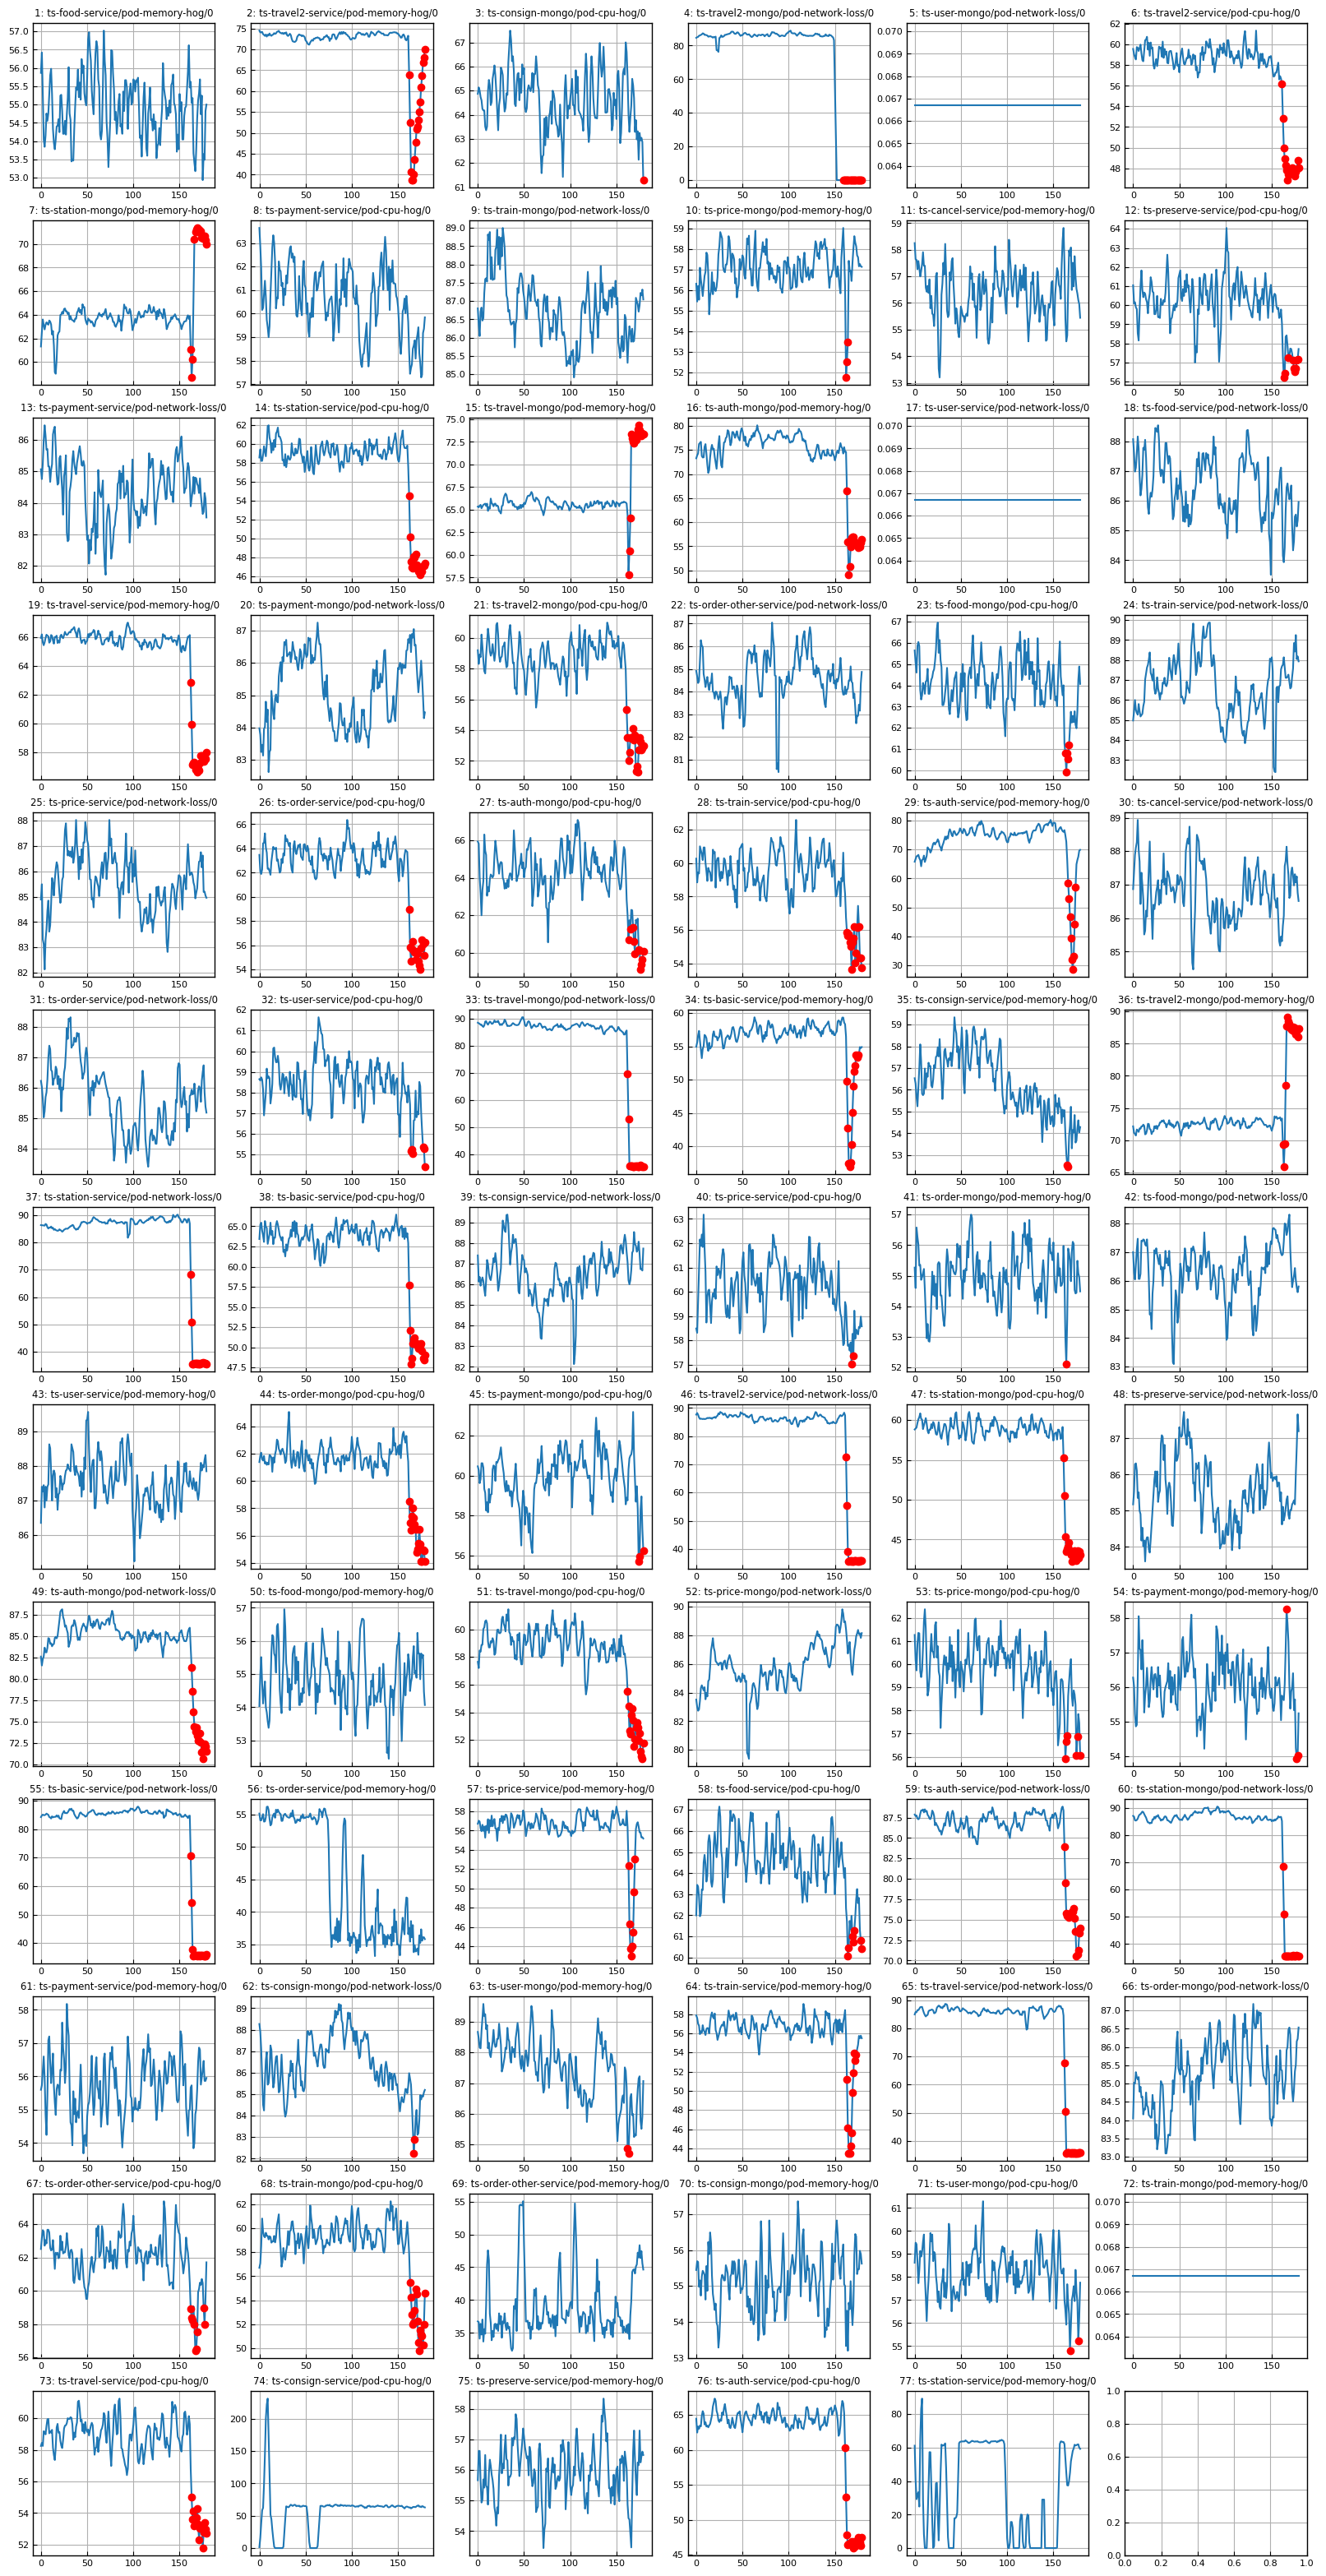

In [ ]:
import math

from tsdr.outlierdetection.n_sigma_rule import detect_with_n_sigma_rule

slis_fig = plt.figure(figsize=(20, 50))
slis_fig, slis_axs = plt.subplots(math.ceil(len(datasets_after_tsdr)/6), 6, figsize=(20, 40))
results = []
for i, (slis_ax, (record, _, _, _)) in enumerate(zip(slis_axs.flatten(), datasets_after_tsdr)):
    sli_name = record.pk.get_root_metrics()[1]
    x = record.data_df[sli_name].to_numpy()
    slis_ax.plot(x)
    title = f"{i+1}: {record.chaos_case_full()}"
    slis_ax.set_title(title)
    outliers = detect_with_n_sigma_rule(
        x=record.data_df[sli_name].to_numpy(),
        test_start_time=record.data_df.shape[0] - (4 * 5 + 1),
        sigma_threshold=3,
        robust=False,
    )
    slis_ax.plot(outliers, x[outliers], 'ro')
    ok = outliers.size > 0
    results.append((record.chaos_case_full(), ok))

In [ ]:
df = pd.DataFrame(results, columns=["chaos_case", "ok"]).query("ok == True")
df.index += 1
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,chaos_case,ok
2,ts-travel2-service/pod-memory-hog/0,True
3,ts-consign-mongo/pod-cpu-hog/0,True
4,ts-travel2-mongo/pod-network-loss/0,True
6,ts-travel2-service/pod-cpu-hog/0,True
7,ts-station-mongo/pod-memory-hog/0,True
10,ts-price-mongo/pod-memory-hog/0,True
12,ts-preserve-service/pod-cpu-hog/0,True
14,ts-station-service/pod-cpu-hog/0,True
15,ts-travel-mongo/pod-memory-hog/0,True
16,ts-auth-mongo/pod-memory-hog/0,True


### SPOT

<Figure size 2000x5000 with 0 Axes>

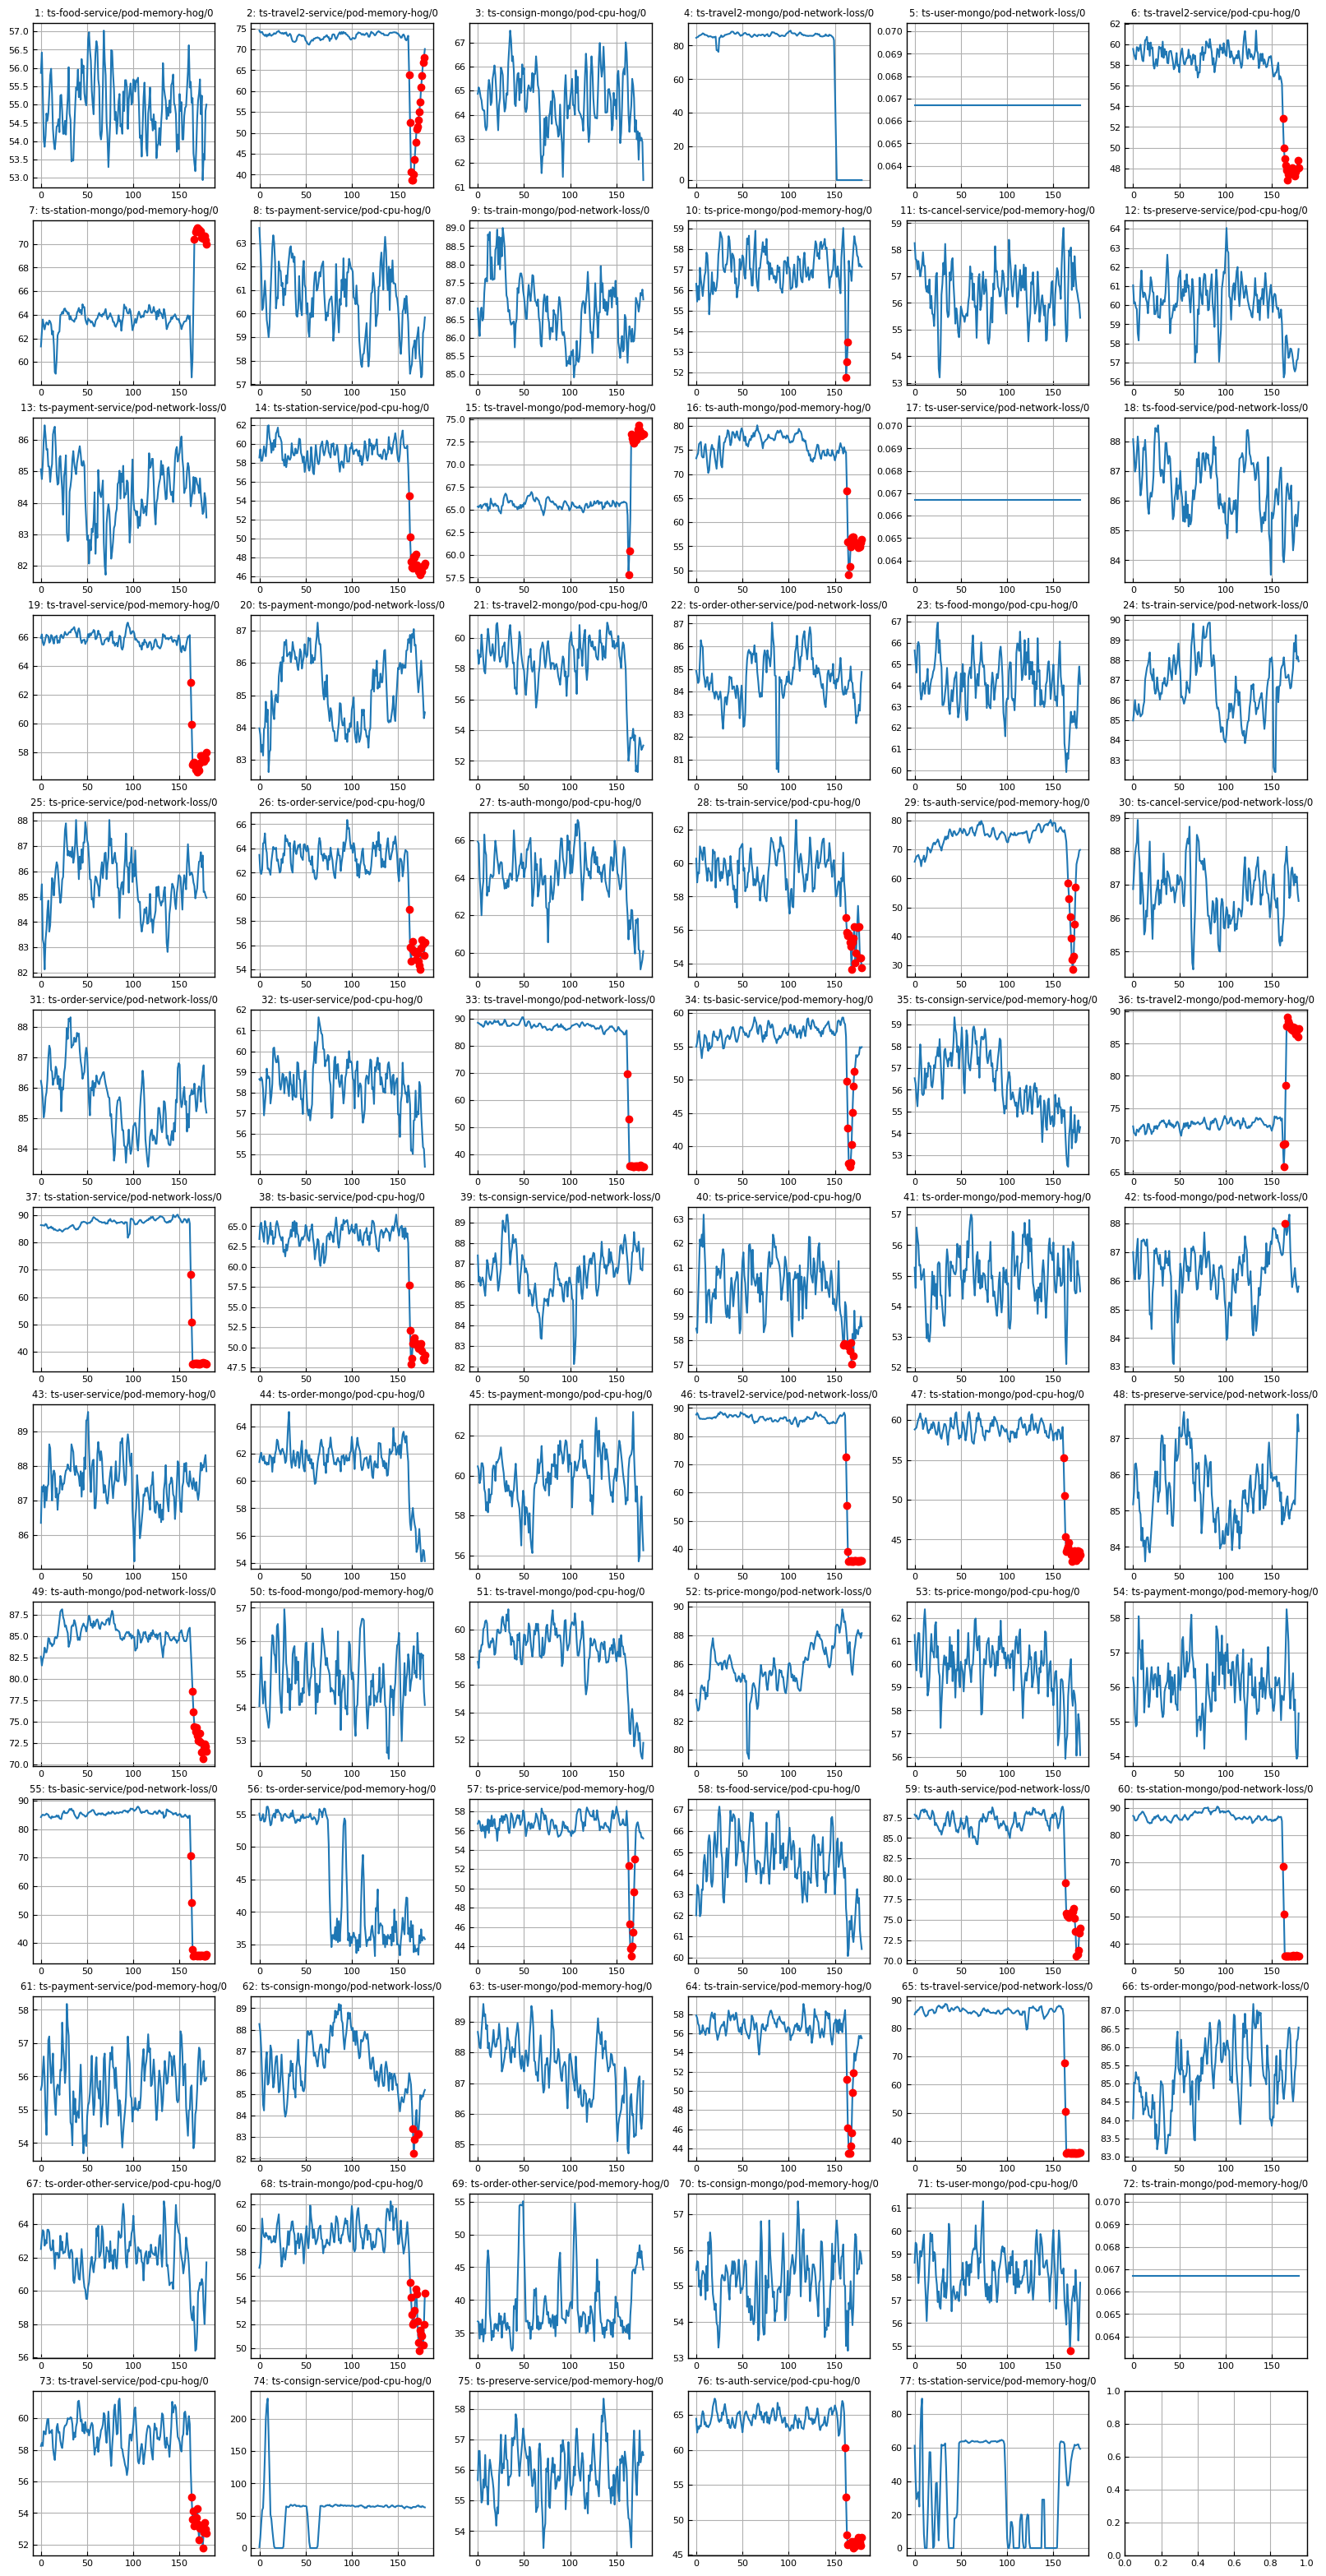

In [ ]:
import math

slis_fig = plt.figure(figsize=(20, 50))
slis_fig, slis_axs = plt.subplots(math.ceil(len(datasets_after_tsdr)/6), 6, figsize=(20, 40))
results = []
for i, (slis_ax, (record, _, _, _)) in enumerate(zip(slis_axs.flatten(), datasets_after_tsdr)):
    sli_name = record.pk.get_root_metrics()[1]
    x = record.data_df[sli_name].to_numpy()
    slis_ax.plot(x)
    title = f"{i+1}: {record.chaos_case_full()}"
    slis_ax.set_title(title)

    test_start_time = x.shape[0] - (4 * 5 + 1)
    train, test = x[:test_start_time], x[test_start_time:]
    scores, alarms = spot(train, test, proba=1e-4, n_points=10)
    outliers = test_start_time + alarms
    if len(outliers) > 0:
        slis_ax.plot(outliers, x[outliers], 'ro')
    ok = outliers.size > 0
    results.append((record.chaos_case_full(), ok))

In [ ]:
df = pd.DataFrame(results, columns=["chaos_case", "ok"]).query("ok == True")
df.index += 1
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,chaos_case,ok
2,ts-travel2-service/pod-memory-hog/0,True
6,ts-travel2-service/pod-cpu-hog/0,True
7,ts-station-mongo/pod-memory-hog/0,True
10,ts-price-mongo/pod-memory-hog/0,True
14,ts-station-service/pod-cpu-hog/0,True
15,ts-travel-mongo/pod-memory-hog/0,True
16,ts-auth-mongo/pod-memory-hog/0,True
19,ts-travel-service/pod-memory-hog/0,True
26,ts-order-service/pod-cpu-hog/0,True
28,ts-train-service/pod-cpu-hog/0,True
